In [1]:
import numpy as np 
import pandas as pd
import math
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
def import_data():
 data = pd.read_csv('norway_new_car_sales_by_make.csv')
 
 data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)
 
 df = pd.pivot_table(data=data,values='Quantity',index='Make',columns='Period',aggfunc='sum',fill_value=0)
 return df

In [3]:
def datasets(df, x_len=12, y_len=1, test_loops=12):
 D = df.values
 rows, periods = D.shape
 # Training set creation
 loops = periods + 1- x_len- y_len
 train = []
 for col in range(loops):
    train.append(D[:,col:col+x_len+y_len])
 
 train = np.vstack(train)
 print(train.shape)
 X_train, Y_train = np.split(train,[-y_len],axis=1)
 # Test set creation
 if test_loops > 0:
    X_train, X_test = np.split(X_train,[-rows*test_loops],axis=0)

    Y_train, Y_test = np.split(Y_train,[-rows*test_loops],axis=0)
 else: # No test set: X_test is used to generate the future forecast
    X_test = D[:,-x_len:]
    Y_test = np.full((X_test.shape[0],y_len),np.nan) #Dummy value
 # Formatting required for scikit-learn
 if y_len == 1:
    Y_train = Y_train.ravel()
    Y_test = Y_test.ravel()
 return X_train, Y_train, X_test, Y_test

In [4]:
def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=''):
 df = pd.DataFrame(columns = ['MAE','RMSE','Bias'],index=['Train','Test'])
 df.index.name = name
 
 df.loc['Train','MAE'] = 100*np.mean(abs(Y_train-Y_train_pred))/np.mean(Y_train)

 df.loc['Train','RMSE'] = 100*np.sqrt(np.mean((Y_train-Y_train_pred)**2))/np.mean(Y_train)
 
 df.loc['Train','Bias'] = 100*np.mean((Y_train- Y_train_pred))/np.mean(Y_train)

 df.loc['Test','MAE'] = 100*np.mean(abs(Y_test- Y_test_pred))/np.mean(Y_test)
 
 df.loc['Test','RMSE'] = 100*np.sqrt(np.mean((Y_test-Y_test_pred)**2))/np.mean(Y_test)
 
 df.loc['Test','Bias'] = 100*np.mean((Y_test- Y_test_pred))/np.mean(Y_test)
 df = df.astype(float).round(1) #Round number for display
 print(df)

In [5]:
df = import_data()
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=1,test_loops=12)

(7085, 13)


In [23]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(bootstrap=True, max_samples=0.95,max_features=11, min_samples_leaf=12, max_depth=7,min_samples_split=15,n_estimators=50)
forest.fit(X_train,Y_train)

RandomForestRegressor(max_depth=7, max_features=11, max_samples=0.95,
                      min_samples_leaf=12, min_samples_split=15,
                      n_estimators=50)

In [24]:
Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forest')

         MAE  RMSE  Bias
Forest                  
Train   15.1  38.1   0.1
Test    18.0  46.5   3.6


In [25]:
from sklearn.model_selection import RandomizedSearchCV
max_depth = list(range(5,11)) + [None]
min_samples_split = range(5,20)
min_samples_leaf = range(2,15)
max_features = range(3,8)
bootstrap = [True] #We force bootstrap
max_samples = [.7,.8,.9,.95,1]
param_dist = {'max_depth': max_depth,'min_samples_split': min_samples_split,'min_samples_leaf': min_samples_leaf,'max_features': max_features,'bootstrap': bootstrap,'max_samples': max_samples}
forest = RandomForestRegressor(n_jobs=1, n_estimators=30)
forest_cv = RandomizedSearchCV(forest, param_dist, cv=6, n_jobs=-1, verbose=2, n_iter=400, scoring='neg_mean_absolute_error')
forest_cv.fit(X_train,Y_train)

Fitting 6 folds for each of 400 candidates, totalling 2400 fits


RandomizedSearchCV(cv=6,
                   estimator=RandomForestRegressor(n_estimators=30, n_jobs=1),
                   n_iter=400, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [5, 6, 7, 8, 9, 10, None],
                                        'max_features': range(3, 8),
                                        'max_samples': [0.7, 0.8, 0.9, 0.95, 1],
                                        'min_samples_leaf': range(2, 15),
                                        'min_samples_split': range(5, 20)},
                   scoring='neg_mean_absolute_error', verbose=2)

In [29]:
print(forest_cv.best_params_)
Y_train_pred = forest_cv.predict(X_train)
Y_test_pred = forest_cv.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forest optimized')


{'min_samples_split': 8, 'min_samples_leaf': 6, 'max_samples': 0.95, 'max_features': 5, 'max_depth': 9, 'bootstrap': True}
                   MAE  RMSE  Bias
Forest optimized                  
Train             13.6  34.3   0.1
Test              17.6  45.9   2.9


In [30]:
#Testing with more no.of trees in forest
forest = RandomForestRegressor(n_estimators=200, n_jobs=-1,**forest_cv.best_params_)
forest = forest.fit(X_train, Y_train)
Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forestx200')

             MAE  RMSE  Bias
Forestx200                  
Train       13.5  34.0   0.0
Test        17.6  45.2   2.6


<Axes: xlabel='features', ylabel='Importance'>

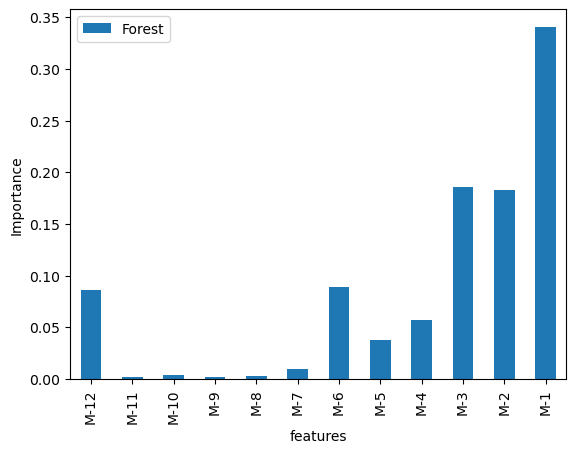

In [35]:
#Checking feauture importance
cols = X_train.shape[1] # number of columns in our training sets
features = [f'M-{cols-col}' for col in range(cols)]
data = forest.feature_importances_.reshape(-1,1)
imp = pd.DataFrame(data=data, index=features, columns=['Forest'])
imp.plot(kind='bar',xlabel='features',ylabel='Importance',layout=[12,5])

In [49]:
#Extreme random split (Selects best split at each node)
from sklearn.ensemble import ExtraTreesRegressor
ETR = ExtraTreesRegressor(n_jobs=-1, n_estimators=200, min_samples_split=15, min_samples_leaf=4, max_samples=0.95, max_features=4, max_depth=8, bootstrap=True)
ETR.fit(X_train,Y_train)
Y_train_pred = ETR.predict(X_train)
Y_test_pred = ETR.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='ETR')

        MAE  RMSE  Bias
ETR                    
Train  17.7  43.7   0.0
Test   19.0  47.5   3.1


In [40]:
#optimization
max_depth = list(range(6,13)) + [None]
min_samples_split = range(7,16)
min_samples_leaf = range(2,13)
max_features = range(5,13)
bootstrap = [True] #We force bootstrap
max_samples = [.7,.8,.9,.95,1]
ETR = ExtraTreesRegressor(n_jobs=1, n_estimators=30)
ETR_cv = RandomizedSearchCV(ETR, param_dist, cv=5, verbose=2, n_jobs=-1, n_iter=400, scoring='neg_mean_absolute_error')
ETR_cv.fit(X_train,Y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


RandomizedSearchCV(cv=5,
                   estimator=ExtraTreesRegressor(n_estimators=30, n_jobs=1),
                   n_iter=400, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [5, 6, 7, 8, 9, 10, None],
                                        'max_features': range(3, 8),
                                        'max_samples': [0.7, 0.8, 0.9, 0.95, 1],
                                        'min_samples_leaf': range(2, 15),
                                        'min_samples_split': range(5, 20)},
                   scoring='neg_mean_absolute_error', verbose=2)

In [42]:
Y_train_pred = ETR_cv.predict(X_train)
Y_test_pred = ETR_cv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='ETR_opt')

          MAE  RMSE  Bias
ETR_opt                  
Train    15.8  39.3   0.0
Test     18.1  45.9   2.7


In [44]:
ETRx200 = ExtraTreesRegressor(n_jobs=-1,n_estimators=200, **ETR_cv.best_params_).fit(X_train,Y_train)
Y_train_pred = ETRx200.predict(X_train)
Y_test_pred = ETRx200.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='ETRx200')

          MAE  RMSE  Bias
ETRx200                  
Train    15.6  39.3   0.1
Test     17.9  45.5   2.9


<Axes: xlabel='features', ylabel='Importance'>

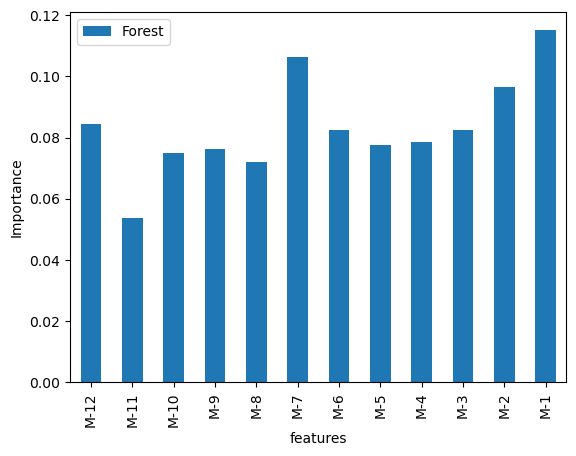

In [50]:
cols = X_train.shape[1]
features = [f'M-{cols-col}' for col in range(cols)]
data = ETR.feature_importances_.reshape(-1,1)
imp = pd.DataFrame(data=data, index=features, columns=['Forest'])
imp.plot(kind='bar',xlabel='features',ylabel='Importance',layout=[12,5])

In [51]:
#Feature Optimisation

def datasets_holdout(df, x_len=12, y_len=1, test_loops=12, holdout_loops=0):
 D = df.values
 rows, periods = D.shape
 # Training set creation
 train_loops = periods + 1- x_len- y_len- test_loops
 train = []
 for col in range(train_loops):
    train.append(D[:,col:col+x_len+y_len])
 train = np.vstack(train)
 X_train, Y_train = np.split(train,[-y_len],axis=1)
 # Holdout set creation
 if holdout_loops > 0:
    X_train, X_holdout = np.split(X_train,[-rows*holdout_loops],axis=0)
    Y_train, Y_holdout = np.split(Y_train,[-rows*holdout_loops],axis=0)
 else:
    X_holdout, Y_holdout = np.array([]), np.array([])
 # Test set creation
 if test_loops > 0:
    X_train, X_test = np.split(X_train,[-rows*test_loops],axis=0)
    Y_train, Y_test = np.split(Y_train,[-rows*test_loops],axis=0)
 else: # No test set: X_test is used to generate the future forecast
    X_test = D[:,-x_len:]
    Y_test = np.full((X_test.shape[0],y_len),np.nan) #Dummy value
 # Formatting required for scikit-learn
 if y_len == 1:
    Y_train = Y_train.ravel()
    Y_test = Y_test.ravel()
    Y_holdout = Y_holdout.ravel()
 return X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test


In [52]:
def model_mae(model, X, Y):
 Y_pred = model.predict(X)
 mae = np.mean(np.abs(Y- Y_pred))/np.mean(Y)
 return mae

In [54]:
df = import_data()
forest_features = {'n_jobs':-1, 'n_estimators':200,'min_samples_split': 15, 'min_samples_leaf': 4, 'max_samples': 0.95, 'max_features': 0.3, 'max_depth': 8, 'bootstrap': True}
forest = RandomForestRegressor(**forest_features)
ETR_features = {'n_jobs':-1, 'n_estimators':200, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_samples': 0.9, 'max_features': 1.0,'max_depth': 12, 'bootstrap': True}
ETR = ExtraTreesRegressor(**ETR_features)
models = [('Forest',forest), ('ETR',ETR)]

In [60]:
df

Period,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,...,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
Make,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,16,9,21,20,17,21,14,12,15,10,...,3,1,2,1,6,15,3,4,3,6
Aston Martin,0,0,1,0,4,3,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Audi,599,498,682,556,630,498,562,590,393,554,...,685,540,551,687,794,688,603,645,827,565
BMW,352,335,365,360,431,477,403,348,271,562,...,1052,832,808,636,1031,1193,1096,1663,866,1540
Bentley,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Think,2,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Toyota,2884,1885,1833,1300,1866,1620,1901,1783,1303,1648,...,1432,1687,1603,1127,1824,1823,1327,1375,1238,1526
Volkswagen,2521,1517,1428,1257,1934,1531,1777,1665,1373,1941,...,3017,2222,2287,2076,2359,2084,2161,2106,2239,1688


In [58]:
n_months = [6,12,24]
results = []
for x_len in n_months: 
 X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test = datasets_holdout(df, x_len=x_len, holdout_loops=12)
 for name, model in models:
    model.fit(X_train,Y_train)
    mae_train = model_mae(model, X_train, Y_train)
    mae_holdout = model_mae(model, X_holdout, Y_holdout)
    mae_test = model_mae(model, X_test, Y_test)
    results.append([name+' Train',mae_train,x_len])
    results.append([name+' Test',mae_test,x_len])
    results.append([name+' Holdout',mae_holdout,x_len])

Model
ETR Holdout       24
ETR Test          12
ETR Train         24
Forest Holdout    24
Forest Test       12
Forest Train      24
dtype: int64


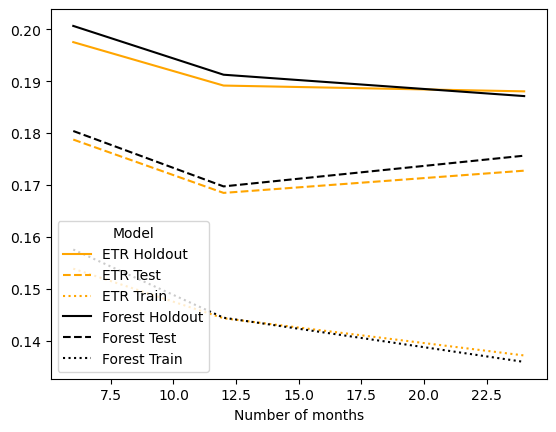

In [59]:
data = pd.DataFrame(results,columns=['Model','MAE%','Number of Months'])
data = data.set_index(['Number of Months','Model']).stack().unstack('Model')
data.index = data.index.droplevel(level=1)
data.index.name = 'Number of months'
data.plot(color=['orange']*3+['black']*3,style=['-','--',':']*3)
print(data.idxmin())